In [ ]:
# 1. Initialize Client and Load Data

import pandas as pd
import numpy as np
from agentds import BenchmarkClient

# 🔑 REPLACE WITH YOUR CREDENTIALS
client = BenchmarkClient(
    api_key="your-api-key-here",        # Get from your team dashboard
    team_name="your-team-name-here"     # Your exact team name
)

print("📂 Loading Commerce Challenge 3 data...")

# Load coupon offers data
train_coupons = pd.read_csv("../datasets/coupon_offers_train.csv")
test_coupons = pd.read_csv("../datasets/coupon_offers_test.csv")

print(f"✅ Data loaded:")
print(f"   Train coupons: {train_coupons.shape}")
print(f"   Test coupons: {test_coupons.shape}")
print(f"   Train columns: {list(train_coupons.columns)}")
print(f"   Test columns: {list(test_coupons.columns)}")

📂 Loading Commerce Challenge 3 data...
✅ Data loaded:
   Train coupons: (500, 10)
   Test coupons: (500, 10)
   Train columns: ['offer_id', 'customer_id', 'sku_id', 'category', 'discount_pct', 'price_tier', 'hist_spend', 'email_open_rate', 'avg_basket_value', 'target_redeem']
   Test columns: ['offer_id', 'customer_id', 'sku_id', 'category', 'discount_pct', 'price_tier', 'hist_spend', 'email_open_rate', 'avg_basket_value', '_Z_cont']


In [480]:
import json

with open("../datasets/session_events.json") as f:
    sessions = json.load(f)

# Flatten JSON
records = []
for s in sessions:
    cid = s["customer_id"]
    events = s["events"]
    for e in events:
        e["customer_id"] = cid
        records.append(e)

df = pd.DataFrame(records)

In [481]:
df["title"] = df["title"].str.replace(r"\bitem\b", "", regex=True).str.strip()
# df["sku_id"] = df["sku_id"].apply(lambda x: int(x.round(0)) if pd.notna(x) else np.nan)
df["sku_id"] = df["sku_id"].astype("Int64")
print(df.head())

       type  sku_id  title  days_ago  customer_id           q category
0  view_pdp     465  Dairy         1            1         NaN      NaN
1    search    <NA>    NaN         2            1    oat milk      NaN
2  view_pdp     401  Dairy         3            1         NaN      NaN
3    search    <NA>    NaN         3            1  yogurt cup      NaN
4  view_pdp     476  Dairy         3            1         NaN      NaN


In [482]:
prods = pd.read_csv("../datasets/products.csv")


In [483]:
# Create a mapping from sku_id to (category, subtype)
prod_map = prods.set_index('sku_id')[['category', 'subtype']]

# Mask for wishlist_add rows
mask = df['type'] == 'wishlist_add'

# Update category and q only for wishlist_add rows
df.loc[mask, 'category'] = df.loc[mask, 'sku_id'].map(prod_map['category'])
df.loc[mask, 'q'] = df.loc[mask, 'sku_id'].map(prod_map['subtype'])


In [484]:
# Create a mapping from sku_id to (category, subtype)
prod_map = prods.set_index('sku_id')[['subtype']]

# Mask for wishlist_add rows
mask = df['type'] == 'view_pdp'

# Update category and q only for wishlist_add rows
df.loc[mask, 'q'] = df.loc[mask, 'sku_id'].map(prod_map['subtype'])

In [485]:
'''sku_to_cat = prods.set_index('subtype')['category']
mask = df['type'] == 'search'
df.loc[mask, 'category'] = df.loc[mask, 'q'].map(prod_map['category'])'''

subtype_to_cat = (
    prods.groupby('subtype')['category']
    .agg(lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0])
    .to_dict()
)

# Apply mapping to searches
mask = df['type'] == 'search'
df.loc[mask, 'category'] = df.loc[mask, 'q'].map(subtype_to_cat)

In [486]:
prods = prods[["sku_id", "subtype", "base_price"]]
print(prods.head())

   sku_id subtype  base_price
0       1   water        0.69
1       2   water        0.69
2       3   water        0.69
3       4   water        0.69
4       5   water        0.69


In [487]:
train_coupons = pd.merge(train_coupons, prods, on="sku_id", how="left")
test_coupons = pd.merge(test_coupons, prods, on="sku_id", how="left")
print(train_coupons.head())

   offer_id  customer_id  sku_id          category  discount_pct price_tier  \
0       761          381     236            Snacks             5       high   
1       989          495    1123     Personal Care            26        low   
2       375          188    1389  Small Appliances            25        mid   
3       769          385      86         Beverages            23        mid   
4       307          154    1378  Small Appliances            35       high   

   hist_spend  email_open_rate  avg_basket_value  target_redeem  \
0   49.483256         0.323907         20.467866              1   
1  138.289536         0.358826         87.962243              0   
2  238.530673         0.217886         75.495135              0   
3  228.789153         0.350924         67.021837              1   
4  185.156947         0.076048         42.102794              0   

          subtype  base_price  
0    potato chips        4.28  
1       deodorant        3.56  
2  coffee grinder       39

In [488]:
new_features = (
    df.groupby("customer_id")
      .apply(lambda g: pd.Series({
          "num_searches": (g["type"] == "search").sum(),
          "num_view_category": (g["type"] == "view_category").sum(),
          "num_view_pdp": (g["type"] == "view_pdp").sum(),
          "num_wishlist_add": (g["type"] == "wishlist_add").sum(),
          "recency_search": g.loc[g["type"] == "search", "days_ago"].min() if "search" in g["type"].values else 999,
          "recency_view_pdp": g.loc[g["type"] == "view_pdp", "days_ago"].min() if "view_pdp" in g["type"].values else 999,
          "recency_view_category": g.loc[g["type"] == "view_category", "days_ago"].min() if "view_category" in g["type"].values else 999,
          "recency_wishlist": g.loc[g["type"] == "wishlist_add", "days_ago"].min() if "wishlist_add" in g["type"].values else 999,
      }))
      .reset_index()
)

/var/folders/22/d3vg34ps7016f1vrkgzqcj_00000gn/T/ipykernel_98909/1864806754.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [489]:
train_coupons = train_coupons.merge(new_features, on="customer_id", how="left").fillna(0)
test_coupons = test_coupons.merge(new_features, on="customer_id", how="left").fillna(0)

In [361]:
df["recency_weight"] = 1 / (1 + df["days_ago"])

In [490]:
# if a customer uses view_pdp on the same sku as in the coupon, count how many times they did so

view_pdp_sku = (
    df.loc[df["type"] == "view_pdp"]
    .groupby(["customer_id", "sku_id"])# ["recency_weight"]
    .size() # sum()
    .reset_index(name="view_pdp_same_sku_count")
)

train_coupons = train_coupons.merge(
    view_pdp_sku, on=["customer_id", "sku_id"], how="left"
)
train_coupons["view_pdp_same_sku_count"] = train_coupons["view_pdp_same_sku_count"].fillna(0)

test_coupons = test_coupons.merge(
    view_pdp_sku, on=["customer_id", "sku_id"], how="left"
)
test_coupons["view_pdp_same_sku_count"] = test_coupons["view_pdp_same_sku_count"].fillna(0)

In [491]:
# if a customer uses view_pdp on the same category as in the coupon, count how many times they did so

view_pdp_cat = (
    df.loc[df["type"] == "view_pdp"]
    .groupby(["customer_id", "title"]) # ["recency_weight"]
    .size()
    .reset_index(name="view_pdp_same_category_count")
)

train_coupons = train_coupons.merge(
    view_pdp_cat, left_on=["customer_id", "category"], right_on=["customer_id", "title"], how="left"
)
train_coupons.drop(columns=["title"], inplace=True)
train_coupons["view_pdp_same_category_count"] = train_coupons["view_pdp_same_category_count"].fillna(0)

test_coupons = test_coupons.merge(
    view_pdp_cat, left_on=["customer_id", "category"], right_on=["customer_id", "title"], how="left"
)
test_coupons.drop(columns=["title"], inplace=True)
test_coupons["view_pdp_same_category_count"] = test_coupons["view_pdp_same_category_count"].fillna(0)


In [492]:
view_pdp_sub = (
    df.loc[df["type"] == "view_pdp"]
    .groupby(["customer_id", "q"]) # ["recency_weight"]
    .size()
    .reset_index(name="view_pdp_same_subtype_count")
)

train_coupons = train_coupons.merge(view_pdp_sub, left_on=["customer_id", "subtype"], right_on=["customer_id", "q"], how='left')
train_coupons["view_pdp_same_subtype_count"] = train_coupons["view_pdp_same_subtype_count"].fillna(0)

test_coupons = test_coupons.merge(view_pdp_sub, left_on=["customer_id", "subtype"], right_on=["customer_id", "q"], how='left')
test_coupons["view_pdp_same_subtype_count"] = test_coupons["view_pdp_same_subtype_count"].fillna(0)

train_coupons.drop(columns=["q"], inplace=True)
test_coupons.drop(columns=["q"], inplace=True)

In [493]:
recency_wishlist = (df.loc[df['type']=='wishlist_add']
                    .groupby(['customer_id', 'sku_id'])
                    .size()
                    .reset_index(name="wishlist_same_sku"))

train_coupons = train_coupons.merge(recency_wishlist, on=['customer_id', 'sku_id'], how='left')
train_coupons["wishlist_same_sku"] = train_coupons["wishlist_same_sku"].fillna(0)

test_coupons = test_coupons.merge(recency_wishlist, on=['customer_id', 'sku_id'], how='left')
test_coupons["wishlist_same_sku"] = test_coupons["wishlist_same_sku"].fillna(0)

In [494]:
subtype_wishlist = (df.loc[df['type']=='wishlist_add']
                    .groupby(['customer_id', 'q'])
                    .size()
                    .reset_index(name="wishlist_same_subtype"))

train_coupons = train_coupons.merge(subtype_wishlist, left_on=["customer_id", "subtype"], right_on=["customer_id", "q"], how='left')
train_coupons["wishlist_same_subtype"] = train_coupons["wishlist_same_subtype"].fillna(0)

test_coupons = test_coupons.merge(subtype_wishlist, left_on=["customer_id", "subtype"], right_on=["customer_id", "q"], how='left')
test_coupons["wishlist_same_subtype"] = test_coupons["wishlist_same_subtype"].fillna(0)

In [495]:
category_wishlist = (df.loc[df['type']=='wishlist_add']
                    .groupby(['customer_id', 'category'])
                    .size()
                    .reset_index(name="wishlist_same_category"))

train_coupons = train_coupons.merge(category_wishlist, on=["customer_id", "category"], how='left')
train_coupons["wishlist_same_category"] = train_coupons["wishlist_same_category"].fillna(0)

test_coupons = test_coupons.merge(category_wishlist, on=["customer_id", "category"], how='left')
test_coupons["wishlist_same_category"] = test_coupons["wishlist_same_category"].fillna(0)

In [496]:
view_cat = (
    df.loc[df["type"] == "view_category"]
    .groupby(["customer_id", "category"]) # ["recency_weight"]
    .size()
    .reset_index(name="view_category_same_category_count")
)

train_coupons = train_coupons.merge(
    view_cat, on=["customer_id", "category"], how="left"
)
train_coupons["view_category_same_category_count"] = train_coupons["view_category_same_category_count"].fillna(0)

test_coupons = test_coupons.merge(
    view_cat, on=["customer_id", "category"], how="left"
)
test_coupons["view_category_same_category_count"] = test_coupons["view_category_same_category_count"].fillna(0)

In [497]:
train_coupons.drop(columns=["q"], inplace=True)
search_subtype = (
    df.loc[df["type"] == "search"]
    .groupby(["customer_id", "q"]) # ["recency_weight"]
    .size()
    .reset_index(name="search_same_subtype_count")
)

train_coupons = train_coupons.merge(
    search_subtype, left_on=["customer_id", "subtype"], right_on=["customer_id", "q"], how="left"
)

print(train_coupons.columns)

train_coupons.drop(columns=["q"], inplace=True)
train_coupons["search_same_subtype_count"] = train_coupons["search_same_subtype_count"].fillna(0)

test_coupons.drop(columns=["q"], inplace=True)
test_coupons = test_coupons.merge(
    search_subtype, left_on=["customer_id", "subtype"], right_on=["customer_id", "q"], how="left"
)
test_coupons.drop(columns=["q"], inplace=True)
test_coupons["search_same_subtype_count"] = test_coupons["search_same_subtype_count"].fillna(0)

Index(['offer_id', 'customer_id', 'sku_id', 'category', 'discount_pct',
       'price_tier', 'hist_spend', 'email_open_rate', 'avg_basket_value',
       'target_redeem', 'subtype', 'base_price', 'num_searches',
       'num_view_category', 'num_view_pdp', 'num_wishlist_add',
       'recency_search', 'recency_view_pdp', 'recency_view_category',
       'recency_wishlist', 'view_pdp_same_sku_count',
       'view_pdp_same_category_count', 'view_pdp_same_subtype_count',
       'wishlist_same_sku', 'wishlist_same_subtype', 'wishlist_same_category',
       'view_category_same_category_count', 'q', 'search_same_subtype_count'],
      dtype='object')


In [498]:
search_category = (
    df.loc[df["type"] == "search"]
    .groupby(["customer_id", "category"]) # ["recency_weight"]
    .size()
    .reset_index(name="search_same_category")
)

train_coupons = train_coupons.merge(
    search_category, on=["customer_id", "category"], how="left"
)

test_coupons = test_coupons.merge(
    search_category, on=["customer_id", "category"], how="left"
)

In [244]:
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedGroupKFold

In [372]:
f1_scores = []
acc_scores = []

In [629]:
target = "target_redeem"
features = [c for c in train_coupons.columns if c not in ["customer_id", "sku_id", "offer_id", target, "subtype", "category", "wishlist_same_sku", "view_pdp_same_sku_count", "recency_search",
                                                          "price_tier", "discount_pct", "hist_spend", "email_open_rate", "avg_basket_value", "base_price", "num_view_pdp", 
                                                          "recency_view_category", "recency_wishlist"]]

In [630]:
X_train = train_coupons[features]
y_train = train_coupons[target]
X_test = test_coupons[features]

In [376]:
sgkf = StratifiedGroupKFold(n_splits=5)
for train_idx, val_idx in sgkf.split(X_train, y_train, groups=train_coupons["customer_id"]):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = lgb.LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        n_estimators=200,
        learning_rate=0.1,
        num_leaves=7,
        max_depth=3,
        min_data_in_leaf=20,
        feature_fraction=1.0,
        random_state=42,
    )

    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="binary_logloss",
    )

    # Predict on validation fold
    y_pred = model.predict(X_val)
    
    # Evaluate
    f1 = f1_score(y_val, y_pred, average="macro")
    acc = accuracy_score(y_val, y_pred)
    
    f1_scores.append(f1)
    acc_scores.append(acc)


In [377]:
print("Stratified 5-Fold CV Results:")
print("F1_macro: %.4f ± %.4f" % (np.mean(f1_scores), np.std(f1_scores)))
print("Accuracy: %.4f ± %.4f" % (np.mean(acc_scores), np.std(acc_scores)))

Stratified 5-Fold CV Results:
F1_macro: 0.7526 ± 0.0324
Accuracy: 0.7561 ± 0.0318


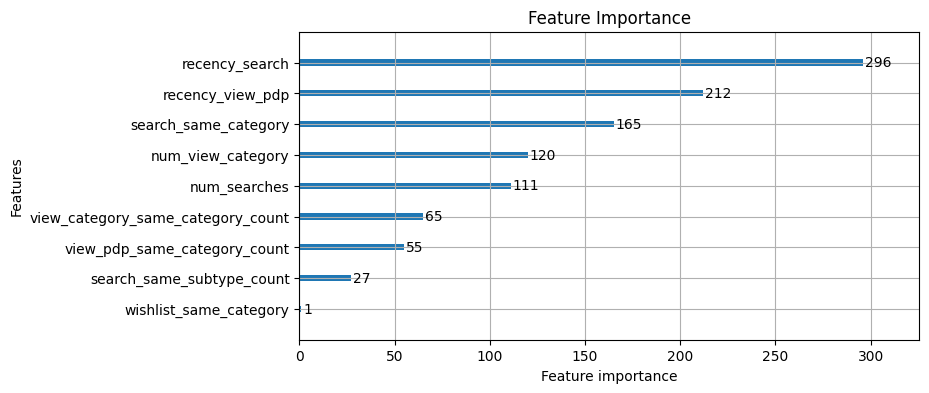

In [378]:
import matplotlib.pyplot as plt
lgb.plot_importance(model, figsize=(8, 4), max_num_features=12)
plt.title("Feature Importance")
plt.show()

In [ ]:
from itertools import product
from tqdm import tqdm
import random

# --- GroupKFold setup ---
groups = train_coupons["customer_id"].values
gkf = StratifiedGroupKFold(n_splits=5)

# --- Parameter grid ---

param_grid = {
    'num_leaves': [8, 16],          # smaller num_leaves to prevent overfitting
    # 'max_depth': [3, 5],         # limit tree depth
    'learning_rate': [0.01, 0.05, 0.1], # smaller for more stable training
    # 'n_estimators': [100, 200, 1000],     # fewer trees due to small data
    #'min_data_in_leaf': [5, 10, 20],    # control leaf size to prevent overfitting
    'feature_fraction': [0.6, 0.8, 1.0],# subset of features per tree
    #'bagging_fraction': [0.6, 0.8, 1.0],# subsample for boosting
    #'bagging_freq': [0, 1],             # 0 = no bagging, 1 = bagging every iteration
}

param_combos = list(product(*param_grid.values()))

best_score = 0
best_params = None

#param_combos = random.sample(param_combos, 30)

# --- Start tuning ---
for combo in tqdm(param_combos, desc="Tuning LGBM (MSE)"):
    params = dict(zip(param_grid.keys(), combo))
    params.update({
        "objective": "binary",       
        "metric": 'binary_logloss',
        "verbose": -1,
        "seed": 42,
        #"learning_rate": 0.1,
        "n_estimators": 200,
        "min_data_in_leaf": 20,
        "bagging_freq": 0,
        "max_depth": 3
        #"n_estimators": 1000,
        #"learning_rate": 0.01
    })

    fold_scores = []

    for tr_idx, val_idx in gkf.split(X_train, y_train, groups):  # Use original (non-log) target
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="binary_logloss",
        )

        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average="macro")
        fold_scores.append(f1)

    mean_f1 = np.mean(fold_scores)

    print(f"{params} => f1: {mean_f1:.6f}")
    if mean_f1 > best_score:
        best_score = mean_f1
        best_params = params

print("\n✅ Best params:", best_params)
print("✅ Best mean f1:", best_score)


Tuning LGBM (MSE):   6%|▌         | 1/18 [00:28<08:07, 28.68s/it]

{'num_leaves': 8, 'learning_rate': 0.003, 'feature_fraction': 0.6, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.752647


Tuning LGBM (MSE):  11%|█         | 2/18 [00:53<07:05, 26.59s/it]

{'num_leaves': 8, 'learning_rate': 0.003, 'feature_fraction': 0.8, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.752523


Tuning LGBM (MSE):  17%|█▋        | 3/18 [01:18<06:28, 25.91s/it]

{'num_leaves': 8, 'learning_rate': 0.003, 'feature_fraction': 1.0, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.754701


Tuning LGBM (MSE):  22%|██▏       | 4/18 [01:47<06:17, 26.98s/it]

{'num_leaves': 8, 'learning_rate': 0.005, 'feature_fraction': 0.6, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.754226


Tuning LGBM (MSE):  28%|██▊       | 5/18 [02:12<05:42, 26.33s/it]

{'num_leaves': 8, 'learning_rate': 0.005, 'feature_fraction': 0.8, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.749787


Tuning LGBM (MSE):  33%|███▎      | 6/18 [02:37<05:10, 25.91s/it]

{'num_leaves': 8, 'learning_rate': 0.005, 'feature_fraction': 1.0, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.741640


Tuning LGBM (MSE):  39%|███▉      | 7/18 [03:06<04:53, 26.68s/it]

{'num_leaves': 8, 'learning_rate': 0.01, 'feature_fraction': 0.6, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.742338


Tuning LGBM (MSE):  44%|████▍     | 8/18 [03:31<04:21, 26.16s/it]

{'num_leaves': 8, 'learning_rate': 0.01, 'feature_fraction': 0.8, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.746413


Tuning LGBM (MSE):  50%|█████     | 9/18 [03:56<03:52, 25.79s/it]

{'num_leaves': 8, 'learning_rate': 0.01, 'feature_fraction': 1.0, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.750430


Tuning LGBM (MSE):  56%|█████▌    | 10/18 [04:24<03:33, 26.68s/it]

{'num_leaves': 16, 'learning_rate': 0.003, 'feature_fraction': 0.6, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.752647


Tuning LGBM (MSE):  61%|██████    | 11/18 [04:49<03:03, 26.22s/it]

{'num_leaves': 16, 'learning_rate': 0.003, 'feature_fraction': 0.8, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.752523


Tuning LGBM (MSE):  67%|██████▋   | 12/18 [05:15<02:35, 25.90s/it]

{'num_leaves': 16, 'learning_rate': 0.003, 'feature_fraction': 1.0, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.754701


Tuning LGBM (MSE):  72%|███████▏  | 13/18 [05:43<02:13, 26.73s/it]

{'num_leaves': 16, 'learning_rate': 0.005, 'feature_fraction': 0.6, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.754226


Tuning LGBM (MSE):  78%|███████▊  | 14/18 [06:08<01:44, 26.23s/it]

{'num_leaves': 16, 'learning_rate': 0.005, 'feature_fraction': 0.8, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.749787


Tuning LGBM (MSE):  83%|████████▎ | 15/18 [06:33<01:17, 25.86s/it]

{'num_leaves': 16, 'learning_rate': 0.005, 'feature_fraction': 1.0, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.741640


Tuning LGBM (MSE):  89%|████████▉ | 16/18 [07:02<00:53, 26.62s/it]

{'num_leaves': 16, 'learning_rate': 0.01, 'feature_fraction': 0.6, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.742338


Tuning LGBM (MSE):  94%|█████████▍| 17/18 [07:27<00:26, 26.20s/it]

{'num_leaves': 16, 'learning_rate': 0.01, 'feature_fraction': 0.8, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.746413


Tuning LGBM (MSE): 100%|██████████| 18/18 [07:52<00:00, 26.24s/it]

{'num_leaves': 16, 'learning_rate': 0.01, 'feature_fraction': 1.0, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3} => f1: 0.750430

✅ Best params: {'num_leaves': 8, 'learning_rate': 0.003, 'feature_fraction': 1.0, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 4000, 'min_data_in_leaf': 20, 'bagging_freq': 0, 'max_depth': 3}
✅ Best mean f1: 0.7547009133048465


In [667]:
final_model = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=20,
    max_depth=4,
    min_data_in_leaf=40,
    feature_fraction=1.0,
    random_state=42,
)

final_model.fit(
    X_train,
    y_train,
    eval_metric="binary_logloss",
    # categorical_feature=["price_tier"],
)

,boosting_type,'gbdt'
,num_leaves,20
,max_depth,4
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


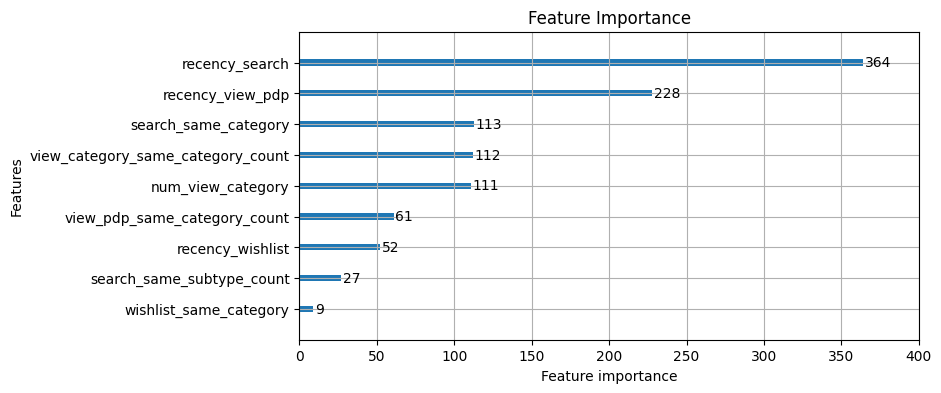

In [561]:
import matplotlib.pyplot as plt
lgb.plot_importance(final_model, figsize=(8, 4), max_num_features=10)
plt.title("Feature Importance")
plt.show()

In [668]:
predictions = final_model.predict(X_test)

In [669]:
submission_df = pd.DataFrame({
    'offer_id': test_coupons['offer_id'],
    'target_redeem': predictions
})

# Save predictions
submission_df.to_csv("commerce_challenge3_predictions.csv", index=False)
print(f"✅ Predictions saved: {submission_df.shape[0]} predictions")
print(f"   Preview: {submission_df.head(3)}")
print(f"   Redemption rate: {predictions.mean():.3f} ({predictions.sum()} redeemed out of {len(predictions)})")

✅ Predictions saved: 500 predictions
   Preview:    offer_id  target_redeem
0       949              0
1       571              0
2       604              0
   Redemption rate: 0.416 (208 redeemed out of 500)


In [670]:
# 3. Submit Predictions

# Submit predictions to the competition
print("🚀 Submitting predictions...")

try:
    result = client.submit_prediction("Commerce", 3, "commerce_challenge3_predictions.csv")
    
    if result['success']:
        print("✅ Submission successful!")
        print(f"   📊 Score: {result['score']:.4f}")
        print(f"   📏 Metric: {result['metric_name']}")
        print(f"   ✔️  Validation: {'Passed' if result['validation_passed'] else 'Failed'}")
    else:
        print("❌ Submission failed!")
        print(f"   Error details: {result.get('details', {}).get('validation_errors', 'Unknown error')}")
        
except Exception as e:
    print(f"💥 Submission error: {e}")
    print("🔧 Check your API key and team name are correct!")

print("\n🎯 Next steps:")
print("   1. Try incorporating relevant information outside this table!")
print("   2. You've completed all Commerce challenges!")


🚀 Submitting predictions...
✅ Prediction submitted successfully!
📊 Score: 0.7725 (Macro-F1)
✅ Validation passed
✅ Submission successful!
   📊 Score: 0.7725
   📏 Metric: Macro-F1
   ✔️  Validation: Passed

🎯 Next steps:
   1. Try incorporating relevant information outside this table!
   2. You've completed all Commerce challenges!
